Here, we'll try different machine learning classification algorithms to predict survival in the Titanic dataset (https://www.kaggle.com/c/titanic). First, import the necessary libraries:

In [76]:
%matplotlib inline

import matplotlib.pyplot as plt
import graphviz
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

pd.set_option('display.max_rows', 300)

Read in and inspect the data:

In [77]:
train = pd.read_csv('train.csv')
train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Pain, Dr. Alfred",male,NaN,NaN,NaN,1601,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


Pclass is the ticket class, and seems like a good predictor of survival without any further recoding:

In [78]:
train[['Pclass', 'Survived']].groupby('Pclass').agg(('mean', 'count')).sort_values(by=(('Survived', 'mean')), ascending=False)

Survived      
            mean count
Pclass                
1       0.629630   216
2       0.472826   184
3       0.242363   491

Sex also seems like a good predictor of survival:

In [79]:
train.groupby('Sex').agg(('mean', 'count'))[['Survived']].sort_values(by=(('Survived', 'mean')), ascending=False)

Survived      
            mean count
Sex                   
female  0.742038   314
male    0.188908   577

We define age categories based on inspection of the distribution of ages and of survival by age:

([<matplotlib.axis.XTick at 0x7f217bbda8d0>,
 <a list of 17 Text xticklabel objects>)

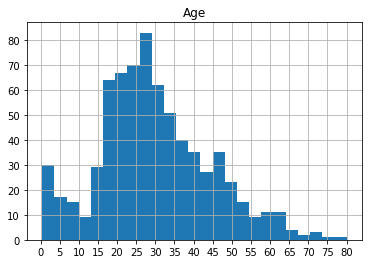

In [80]:
train.hist('Age', bins=25)
plt.xticks(range(0, 85, 5))

In [81]:
train[['Age', 'Survived']].groupby('Age').agg(['mean', 'count'])

Survived      
           mean count
Age                  
0.42   1.000000     1
0.67   1.000000     1
0.75   1.000000     2
0.83   1.000000     2
0.92   1.000000     1
1.00   0.714286     7
2.00   0.300000    10
3.00   0.833333     6
4.00   0.700000    10
5.00   1.000000     4
6.00   0.666667     3
7.00   0.333333     3
8.00   0.500000     4
9.00   0.250000     8
10.00  0.000000     2
11.00  0.250000     4
12.00  1.000000     1
13.00  1.000000     2
14.00  0.500000     6
14.50  0.000000     1
15.00  0.800000     5
16.00  0.352941    17
17.00  0.461538    13
18.00  0.346154    26
19.00  0.360000    25
20.00  0.200000    15
20.50  0.000000     1
21.00  0.208333    24
22.00  0.407407    27
23.00  0.333333    15
23.50  0.000000     1
24.00  0.500000    30
24.50  0.000000     1
25.00  0.260870    23
26.00  0.333333    18
27.00  0.611111    18
28.00  0.280000    25
28.50  0.000000     2
29.00  0.400000    20
30.00  0.400000    25
30.50  0.000000     2
31.00  0.470588    17
32.00  0.500000    18
32.50  0.500000     2
33.00  0.400000    15
34.00  0.400000    15
34.50  0.000000     1
35.00  0.611111    18
36.00  0.500000    22
36.50  0.000000     1
37.00  0.166667     6
38.00  0.454545    11
39.00  0.357143    14
40.00  0.461538    13
40.50  0.000000     2
41.00  0.333333     6
42.00  0.461538    13
43.00  0.200000     5
44.00  0.333333     9
45.00  0.416667    12
45.50  0.000000     2
46.00  0.000000     3
47.00  0.111111     9
48.00  0.666667     9
49.00  0.666667     6
50.00  0.500000    10
51.00  0.285714     7
52.00  0.500000     6
53.00  1.000000     1
54.00  0.375000     8
55.00  0.500000     2
55.50  0.000000     1
56.00  0.500000     4
57.00  0.000000     2
58.00  0.600000     5
59.00  0.000000     2
60.00  0.500000     4
61.00  0.000000     3
62.00  0.500000     4
63.00  1.000000     2
64.00  0.000000     2
65.00  0.000000     3
66.00  0.000000     1
70.00  0.000000     2
70.50  0.000000     1
71.00  0.000000     2
74.00  0.000000     1
80.00  1.000000     1

We examine the presence of siblings/spouses and parents/children, and survival by these two variables:

In [82]:
train['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [83]:
train.groupby('SibSp')['Survived'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)

,mean,count
SibSp,,
1,0.535885,209
2,0.464286,28
0,0.345395,608
3,0.250000,16
4,0.166667,18
5,0.000000,5
8,0.000000,7


In [84]:
train['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [85]:
train.groupby('Parch')['Survived'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)

,mean,count
Parch,,
3,0.600000,5
1,0.550847,118
2,0.500000,80
0,0.343658,678
5,0.200000,5
4,0.000000,4
6,0.000000,1


Based on these descriptives, we will use an indicator for whether any relatives, either siblings/spouses or parents/children, were present.

Next, we look at the distribution of fares and mean fare by survival, which suggest fare is also a good predictor of survival:

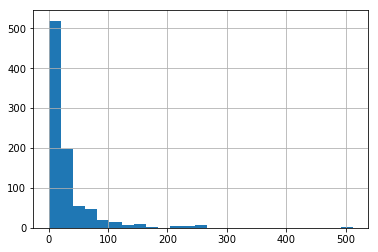

In [86]:
train['Fare'].hist(bins=25)

In [87]:
train.groupby('Survived')['Fare'].agg(['mean', 'count'])

,mean,count
Survived,,
0,22.117887,549
1,48.395408,342


In [88]:
train['Fare'].value_counts(normalize=True).sort_index()

0.0000      0.016835
4.0125      0.001122
5.0000      0.001122
6.2375      0.001122
6.4375      0.001122
6.4500      0.001122
6.4958      0.002245
6.7500      0.002245
6.8583      0.001122
6.9500      0.001122
6.9750      0.002245
7.0458      0.001122
7.0500      0.007856
7.0542      0.002245
7.1250      0.004489
7.1417      0.001122
7.2250      0.013468
7.2292      0.016835
7.2500      0.014590
7.3125      0.001122
7.4958      0.003367
7.5208      0.001122
7.5500      0.004489
7.6292      0.001122
7.6500      0.004489
7.7250      0.001122
7.7292      0.001122
7.7333      0.004489
7.7375      0.002245
7.7417      0.001122
7.7500      0.038159
7.7750      0.017957
7.7875      0.001122
7.7958      0.006734
7.8000      0.001122
7.8292      0.002245
7.8542      0.014590
7.8750      0.001122
7.8792      0.004489
7.8875      0.001122
7.8958      0.042649
7.9250      0.020202
8.0292      0.001122
8.0500      0.048260
8.1125      0.001122
8.1375      0.001122
8.1583      0.001122
8.3000      0

We also consider the point of embarkation, which seems like a potentially worthwhile predictor:

In [89]:
train.groupby('Embarked')['Survived'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)

,mean,count
Embarked,,
C,0.553571,168
Q,0.389610,77
S,0.336957,644


Finally, we will consider the cabin number. It appears that the first letter in the cabin number may identify groups of cabins.

In [90]:
train['Cabin'].value_counts().sort_index()

A10                1
A14                1
A16                1
A19                1
A20                1
A23                1
A24                1
A26                1
A31                1
A32                1
A34                1
A36                1
A5                 1
A6                 1
A7                 1
B101               1
B102               1
B18                2
B19                1
B20                2
B22                2
B28                2
B3                 1
B30                1
B35                2
B37                1
B38                1
B39                1
B4                 1
B41                1
B42                1
B49                2
B5                 2
B50                1
B51 B53 B55        2
B57 B59 B63 B66    2
B58 B60            2
B69                1
B71                1
B73                1
B77                2
B78                1
B79                1
B80                1
B82 B84            1
B86                1
B94                1
B96 B98      

In [91]:
train['Cabin'].str.extract('([a-zA-Z])', expand=False).value_counts(normalize=True)

C    0.289216
B    0.230392
D    0.161765
E    0.156863
A    0.073529
F    0.063725
G    0.019608
T    0.004902
Name: Cabin, dtype: float64

Data are also provided on ticket number and name. We will not use these data, as there are no clear patterns in ticket number and it seems unlikely that the information in name would give us good information beyond what we already have in variables for sex, age, and ticket class.

Next, define functions for initial processing of the data and running some descriptives:

In [92]:
def preprocess(df):
    df = df.copy()
    df['Cabin_class'] = df['Cabin'].str.extract('([a-zA-Z])', expand=False)
    df['Cabin_class'] = df['Cabin_class'].replace(['D', 'E', 'B'], 'D/E/B')
    df['Cabin_class'] = df['Cabin_class'].replace(['F', 'C'], 'F/C')
    df['Cabin_class'] = df['Cabin_class'].replace(['G', 'A'], 'G/A')
    df['Cabin_class'] = df['Cabin_class'].replace('T', np.nan)
    df['Cabin_class'] = df['Cabin_class'].replace(np.nan, 'NS')
    df.loc[df['SibSp'] > 1, 'SibSp'] = 1
    df.loc[df['Parch'] > 2, 'Parch'] = 2
    df['Relatives'] = 0
    df.loc[(df['SibSp'] > 0) | (df['Parch'] > 0), 'Relatives'] = 1
    df['Age_cat'] = pd.cut(df['Age'], [0, 5, 15, 59, 80], right=True)
    df['Fare_cat'] = pd.cut(df['Fare'], [0, 8.5, 26, 80, 513], right=True, include_lowest=True)
    for dummy in ['Pclass', 'Sex', 'Embarked', 'Cabin_class', 'Age_cat', 'Fare_cat',]:
        df = pd.concat([df, pd.get_dummies(df[dummy], dummy)], axis=1)
    return df

In [93]:
train = preprocess(train)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 36 columns):
PassengerId               891 non-null int64
Survived                  891 non-null int64
Pclass                    891 non-null int64
Name                      891 non-null object
Sex                       891 non-null object
Age                       714 non-null float64
SibSp                     891 non-null int64
Parch                     891 non-null int64
Ticket                    891 non-null object
Fare                      891 non-null float64
Cabin                     204 non-null object
Embarked                  889 non-null object
Cabin_class               891 non-null object
Relatives                 891 non-null int64
Age_cat                   714 non-null category
Fare_cat                  891 non-null category
Pclass_1                  891 non-null uint8
Pclass_2                  891 non-null uint8
Pclass_3                  891 non-null uint8
Sex_female              

Define an estimator to select appropriate columns and convert pandas DataFrame to a matrix for use in sklearn pipelines:

In [94]:
columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
		'Cabin_class_D/E/B', 'Cabin_class_F/C', 'Cabin_class_G/A', 'Cabin_class_NS', 'Embarked_S', 'Embarked_C', 'Embarked_Q',
		'Age_cat_(0, 5]', 'Age_cat_(5, 15]', 'Age_cat_(15, 59]', 'Age_cat_(59, 80]',
		'Fare_cat_(-0.001, 8.5]', 'Fare_cat_(8.5, 26.0]', 'Fare_cat_(26.0, 80.0]', 'Fare_cat_(80.0, 513.0]',
		'Relatives',]

class DataFrameSelector(BaseEstimator, TransformerMixin):
	def __init__(self):
		pass

	def fit(self, X, y=None):
		return self

	def transform(self, X):
		global columns
		return X[columns].values

We have a number of potentially relevant features, so we first examine chi-squared scores for all of them to see if there are any we should eliminate in order to reduce dimensionality:

In [95]:
pipe = Pipeline([
    ('selector', DataFrameSelector()),
    ('imputer', Imputer(strategy='median')),
    ('kbest', SelectKBest(chi2, k='all')),
])
pipe.fit(train, train['Survived'])
chi2scores = pipe.named_steps['kbest'].scores_
columns11 = columns[:]
for i, rank in zip(chi2scores.argsort()[::-1], range(len(chi2scores))):
    print('k: {2:<5} {0:30} {1:.3f}'.format(columns[i], chi2scores[i], rank+1))
    if rank+1 > 11: columns11.remove(columns[i])

k: 1     Sex_female                     170.348
k: 2     Sex_male                       92.702
k: 3     Cabin_class_D/E/B              63.492
k: 4     Pclass_1                       55.175
k: 5     Fare_cat_(80.0, 513.0]         46.723
k: 6     Pclass_3                       41.553
k: 7     Fare_cat_(-0.001, 8.5]         41.250
k: 8     Relatives                      22.209
k: 9     Cabin_class_NS                 20.732
k: 10    Embarked_C                     20.464
k: 11    Age_cat_(0, 5]                 19.135
k: 12    Cabin_class_F/C                13.862
k: 13    Fare_cat_(26.0, 80.0]          10.273
k: 14    Pclass_2                       6.161
k: 15    Embarked_S                     5.985
k: 16    Age_cat_(59, 80]               1.444
k: 17    Age_cat_(5, 15]                0.996
k: 18    Cabin_class_G/A                0.648
k: 19    Fare_cat_(8.5, 26.0]           0.040
k: 20    Age_cat_(15, 59]               0.022
k: 21    Embarked_Q                     0.011


Based on these scores, it looks like we will want to experiment with some different k values for SelectKBest: 4, 7, 11, 13, 15, all. For initial model inspection, we'll try k=11.

To begin modeling the data, we'll try running a logistic regression:

In [96]:
pipe = Pipeline([
    ('selector', DataFrameSelector()),
    ('imputer', Imputer(strategy='median')),
    ('kbest', SelectKBest(chi2, k=11)),
    ('clf', LogisticRegression()),
])
pipe.fit(train, train['Survived'])
for i, col in enumerate(columns11):
    print('{0:30} {1: .3f}'.format(col, pipe.named_steps['clf'].coef_[0][i]))

Pclass_1                        0.110
Pclass_3                       -1.127
Sex_female                      1.446
Sex_male                       -1.208
Cabin_class_D/E/B               0.805
Cabin_class_NS                 -0.456
Embarked_C                      0.553
Age_cat_(0, 5]                  1.791
Fare_cat_(-0.001, 8.5]          0.285
Fare_cat_(80.0, 513.0]          0.312
Relatives                      -0.140


Next, consider a decision tree.

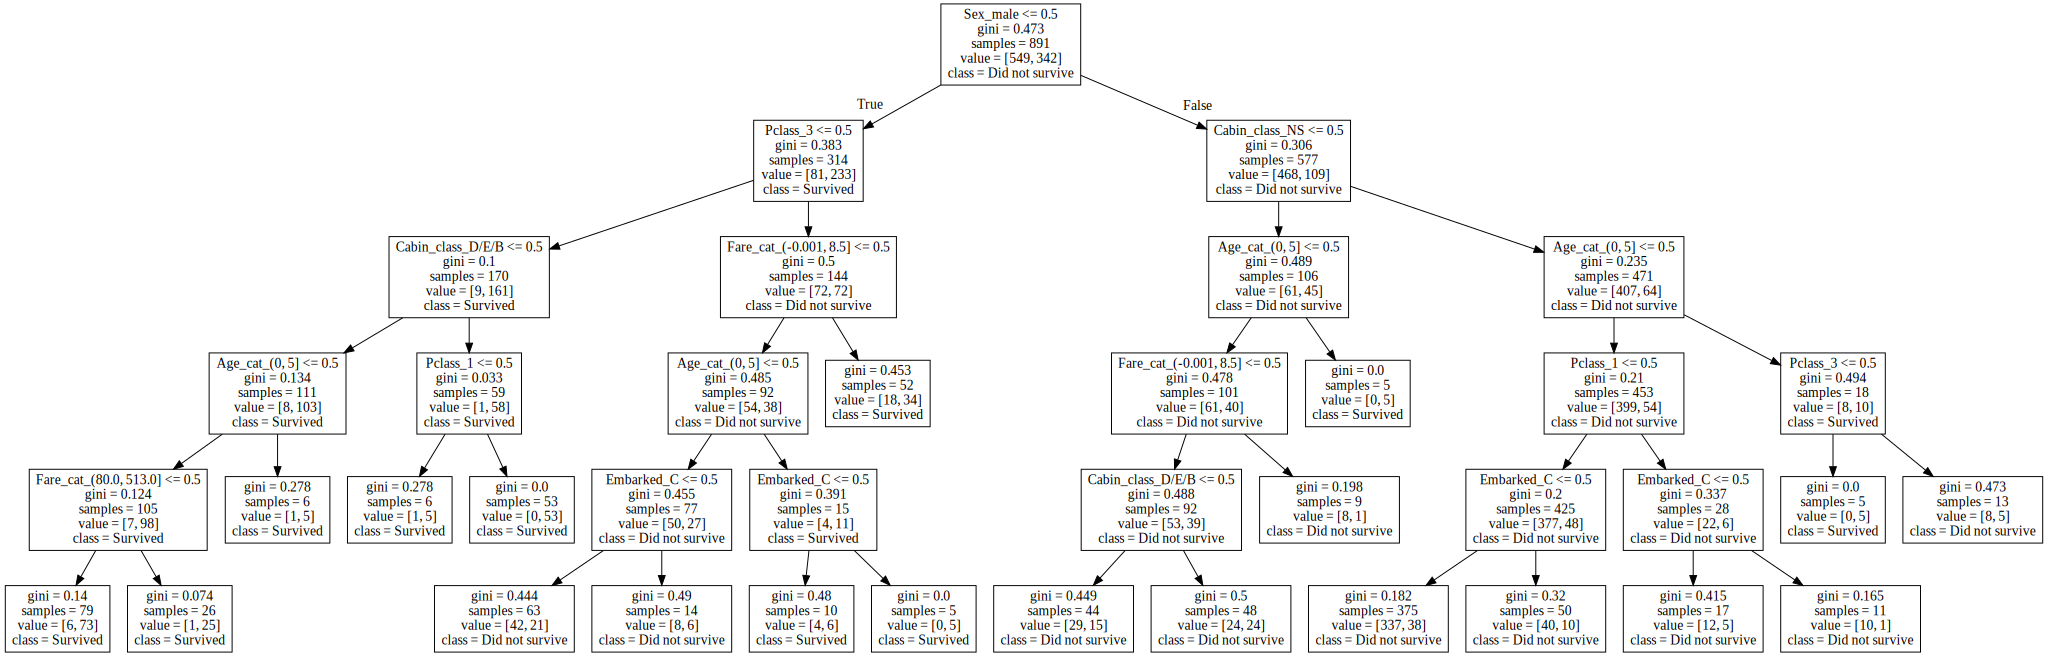

In [97]:
pipe = Pipeline([
    ('selector', DataFrameSelector()),
    ('imputer', Imputer(strategy='median')),
    ('kbest', SelectKBest(chi2, k=11)),
    ('clf', DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)),
])
pipe.fit(train, train['Survived'])
dot_data = export_graphviz(pipe.named_steps['clf'],
                           feature_names=columns11, class_names=['Did not survive', 'Survived'],
                           out_file=None)
graph = graphviz.Source(dot_data)
graph

We'll try different hyperparameter values for these two models, as well as a random forest classifier and a support vector classifier, in the grid search below:

In [98]:
pipe = Pipeline([
	('selector', DataFrameSelector()),
	('imputer', Imputer(strategy = 'median')),
	('kbest', SelectKBest(chi2)),
	('clf', SVC(kernel='rbf')),
])

param_grid = [{
	'kbest__k': [4, 7, 11, 13, 15, 'all'],
	'clf': [LogisticRegression(C=.1), LogisticRegression(C=1), LogisticRegression(C=10), LogisticRegression(C=100), LogisticRegression(C=1000),
		DecisionTreeClassifier(max_depth=3, min_samples_leaf=5), DecisionTreeClassifier(max_depth=4, min_samples_leaf=5), DecisionTreeClassifier(max_depth=5, min_samples_leaf=5), DecisionTreeClassifier(max_depth=6, min_samples_leaf=5), DecisionTreeClassifier(max_depth=7, min_samples_leaf=5),
		RandomForestClassifier(max_depth=3, min_samples_leaf=5), RandomForestClassifier(max_depth=4, min_samples_leaf=5), RandomForestClassifier(max_depth=5, min_samples_leaf=5), RandomForestClassifier(max_depth=6, min_samples_leaf=5), RandomForestClassifier(max_depth=7, min_samples_leaf=5), 
		LinearSVC(C=.1), LinearSVC(C=1), LinearSVC(C=10), LinearSVC(C=100), LinearSVC(C=1000),],
	},
	{
	'kbest__k': [4, 7, 11, 13, 15, 'all'],
	'clf__C': [5, 10, 15, 20],
	'clf__gamma': [.1, .15, .20, .25, .30],
    }
]

np.random.seed(0)
grid_search = GridSearchCV(pipe, param_grid,
	scoring={'accuracy': make_scorer(accuracy_score)}, refit='accuracy')
grid_search.fit(train, train['Survived'])
print('Best parameters: {0}'.format(grid_search.best_params_))
print('Best accuracy score: {0}'.format(grid_search.best_score_))

Best parameters: {'clf__C': 10, 'clf__gamma': 0.2, 'kbest__k': 15}
Best accuracy score: 0.8237934904601572


The support vector classifier does best, with 82% accuracy. Below, we compare results for all of the models tried:

In [99]:
cvres = grid_search.cv_results_
print('{0:80} {1:>20} {2:>20}'.format('Parameters', 'Train Accuracy', 'Test Accuracy',))
for train_accuracy, test_accuracy, params in zip(cvres['mean_train_accuracy'], cvres['mean_test_accuracy'], cvres['params']):
	print('{0:80.80} {1:>20.5f} {2:>20.5f}'.format(str(params).replace('\n', ''), train_accuracy, test_accuracy))

Parameters                                                                             Train Accuracy        Test Accuracy
{'clf': LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=T              0.78900              0.77778
{'clf': LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=T              0.78900              0.76655
{'clf': LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=T              0.79349              0.76880
{'clf': LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=T              0.79293              0.76880
{'clf': LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=T              0.79293              0.76655
{'clf': LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=T              0.79125              0.76543
{'clf': LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=Tru              0.78732              0.78002
{'clf': Logistic

And we display further statistics on our chosen SVC model:

In [100]:
pred = cross_val_predict(grid_search.best_estimator_, train, train['Survived'])
print(confusion_matrix(train['Survived'], pred))
print('Precision: ', precision_score(train['Survived'], pred))
print('Recall: ', recall_score(train['Survived'], pred))
print('F1: ', f1_score(train['Survived'], pred))
print('Accuracy: ', accuracy_score(train['Survived'], pred))

[[499  50]
 [107 235]]
Precision:  0.824561403509
Recall:  0.687134502924
F1:  0.749601275917
Accuracy:  0.82379349046


Finally, we run the final model on the test data and prepare a submission file.

In [101]:
test = preprocess(pd.read_csv('test.csv'))
test_pred = grid_search.best_estimator_.predict(test)
submission = test[['PassengerId']].copy()
submission['Survived'] = test_pred
submission.to_csv('submission.csv', index=False)